In [4]:
import pandas as pd
transaction=pd.read_csv('Book1.csv')
purchase=pd.read_csv('QVI_purchase_behaviour.csv')
transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


DATA CLEANING

In [5]:
transaction['TOT_SALES'].max(),transaction['TOT_SALES'].min()
transaction['PROD_QTY'].max(),transaction['PROD_QTY'].min()

(np.int64(200), np.int64(1))

In [8]:
transaction[transaction.PROD_QTY>50]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,43331,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,43605,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [6]:
transaction=transaction[transaction.PROD_QTY<50]
transaction['DATE'] = pd.to_datetime(transaction['DATE'], origin='1899-12-30', unit='D')

EDA

In [7]:
transaction['PACK_SIZE'] = transaction['PROD_NAME'].str.extract(r'(\d+)g').astype(float)
transaction['BRAND'] = transaction['PROD_NAME'].str.split().str[0]
transaction['BRAND']=transaction['BRAND'].replace({
    'Smith': 'Smiths',
    'Red':'RRD',
    'Dorito':'Doritos',
    'WW': 'WOOLWORTHS',
    'NCC': 'NATURAL',
    'Infzns': 'INFUZIONS',
    'Snbts': 'SUNBITES',
    'Grain': 'GRNWAVES',
    'GrnWves':'GRNWAVES'})

In [8]:
transaction.head()
purchase.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [9]:
# QUESTION 1
merge=pd.merge(transaction,purchase,on='LYLTY_CARD_NBR')
x=merge.groupby(['LYLTY_CARD_NBR','PREMIUM_CUSTOMER'])['TOT_SALES'].sum()
x

LYLTY_CARD_NBR  PREMIUM_CUSTOMER
1000            Premium              6.0
1002            Mainstream           2.7
1003            Budget               6.6
1004            Mainstream           1.9
1005            Mainstream           2.8
                                    ... 
2370651         Mainstream          13.0
2370701         Mainstream           7.2
2370751         Premium              9.2
2370961         Budget              18.6
2373711         Mainstream          11.4
Name: TOT_SALES, Length: 72636, dtype: float64

In [18]:
#QUESTION 2
transaction['Revenue']=transaction['PROD_QTY']*transaction['TOT_SALES']
merge1=pd.merge(transaction,purchase,on='LYLTY_CARD_NBR')
x=merge1.groupby(['BRAND','PREMIUM_CUSTOMER'])['TOT_SALES'].sum().sort_values(ascending=False)


In [21]:
#QUESTION (matrix by me)

In [22]:
#QUESTION 3 (COMPARING TRIAL AND CONTROL STORES)
#transaction['year_mm']=transaction['DATE'].dt.strftime('%Y%m').astype(int)
ts=transaction.groupby(['year_mm','STORE_NBR'])['TOT_SALES'].sum().reset_index()
NoC=transaction.groupby(['year_mm','STORE_NBR'])['LYLTY_CARD_NBR'].nunique().reset_index()
TxNo=transaction.groupby(['year_mm','STORE_NBR'])['TXN_ID'].nunique().reset_index()
Pq=transaction.groupby(['year_mm','STORE_NBR'])['PROD_QTY'].sum().reset_index()

In [23]:
matrix=pd.merge(ts,NoC,on=['year_mm','STORE_NBR'])
matrix=pd.merge(TxNo,matrix,on=['year_mm','STORE_NBR'])
matrix=pd.merge(Pq,matrix,on=['year_mm','STORE_NBR'])
matrix.rename(columns={
    'STORE_NBR':'Store Number',
    'PROD_QTY':'Total Chips',
    'TXN_ID':' Number of Transactions',
    'LYLTY_CARD_NBR':'Number of Customers',
    'TOT_SALES':'Total Sales'},inplace=True)

In [24]:
pre_trial_store=matrix[matrix['year_mm']<201902]
months_per_store=matrix.groupby('Store Number')['year_mm'].nunique()
a=months_per_store[months_per_store==12].index
pre_trial_store= pre_trial_store[pre_trial_store['Store Number'].isin(a)]
pre_trial_store.head(5)

,year_mm,Store Number,Total Chips,Number of Transactions,Total Sales,Number of Customers
0,201807,1,62,52,206.9,49
1,201807,2,46,41,150.8,39
2,201807,3,271,138,1205.7,112
3,201807,4,318,158,1399.9,128
4,201807,5,240,120,812.0,93


In [25]:
C1=pre_trial_store[pre_trial_store['Store Number']==77]
C2=pre_trial_store[pre_trial_store['Store Number']!=77]

In [26]:
import numpy as np
import pandas as pd

def Best_Control_Store(Trial, pre_trial_store):
    """
    Find best control store for the given trial store, from pre-trial DataFrame T4.
    Uses correlation and magnitude difference in Total Sales and Number of Customers.
    """
    # Split into trial store and candidate stores
    C1 = pre_trial_store[pre_trial_store['Store Number'] == Trial]
    C2 = pre_trial_store[pre_trial_store['Store Number'] != Trial]
    Candidate_stores = C2['Store Number'].unique()

    results = []

    for store in Candidate_stores:
        candidate_data = C2[C2['Store Number'] == store]

        # Merge trial store data with candidate store data on year_mm
        merged = pd.merge(
            C1[['year_mm', 'Total Sales', 'Number of Customers']],
            candidate_data[['year_mm', 'Total Sales', 'Number of Customers']],
            on='year_mm',
            suffixes=('_trial', '_control')
        )
        
        # Calculate correlation
        corr_sales = np.corrcoef(merged['Total Sales_trial'], merged['Total Sales_control'])[0,1]
        corr_customers = np.corrcoef(merged['Number of Customers_trial'], merged['Number of Customers_control'])[0,1]
        
        # Calculate magnitude difference (lower is better)
        mag_sales = np.mean(abs(merged['Total Sales_trial'] - merged['Total Sales_control'])) / np.mean(merged['Total Sales_trial'])
        mag_customers = np.mean(abs(merged['Number of Customers_trial'] - merged['Number of Customers_control'])) / np.mean(merged['Number of Customers_trial'])
        
        # Combine into final score: higher correlation + lower magnitude difference → higher score
        final_score = (corr_sales + corr_customers) / 2 + (1 - (mag_sales + mag_customers) / 2)

        results.append({
            'Candidate_Store': store,
            'corr_sales': corr_sales,
            'corr_customers': corr_customers,
            'mag_sales': mag_sales,
            'mag_customers': mag_customers,
            'final_score': final_score
        })

    # Convert to DataFrame and pick best control store
    results_matrix = pd.DataFrame(results)
    best_store = results_matrix.loc[results_matrix['final_score'].idxmax(), 'Candidate_Store']

    print(f"\n Best control store for trial store {Trial} is: {best_store}")
    return results_matrix, best_store


In [38]:
results_77, control_77 = Best_Control_Store(77, pre_trial_store)


 Best control store for trial store 77 is: 233


In [41]:
results_77, control_77 = Best_Control_Store(86, pre_trial_store)


 Best control store for trial store 86 is: 155


In [40]:
results_77, control_77 = Best_Control_Store(88, pre_trial_store)


 Best control store for trial store 88 is: 237


In [ ]:
##QUESTION 4 (POWER BI)

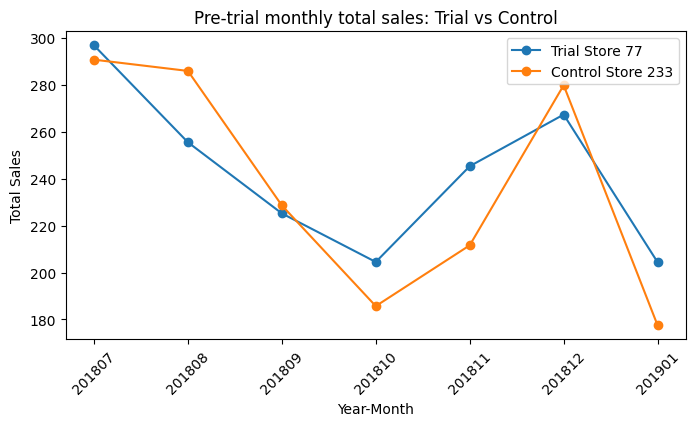

In [27]:
import matplotlib.pyplot as plt
Trial1=pre_trial_store[pre_trial_store['Store Number']==77]
Trial1_grouped = Trial1.groupby('year_mm')['Total Sales'].sum().reset_index()
Control1=pre_trial_store[pre_trial_store['Store Number']==233]
Control1_grouped = Control1.groupby('year_mm')['Total Sales'].sum().reset_index()
plt.figure(figsize=(8,4))

plt.plot(Trial1_grouped['year_mm'].astype(str), Trial1_grouped['Total Sales'], 
         marker='o', label='Trial Store 77')

plt.plot(Control1_grouped['year_mm'].astype(str), Control1_grouped['Total Sales'], 
         marker='o', label='Control Store 233')

plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.title('Pre-trial monthly total sales: Trial vs Control')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [29]:
Trial1
Control1

,year_mm,Store Number,Total Chips,Number of Transactions,Total Sales,Number of Customers
227,201807,233,88,54,290.7,51
489,201808,233,80,50,285.9,48
754,201809,233,70,45,228.6,42
1019,201810,233,56,36,185.7,35
1283,201811,233,62,41,211.6,40
1546,201812,233,75,50,279.8,47
1809,201901,233,47,35,177.5,35


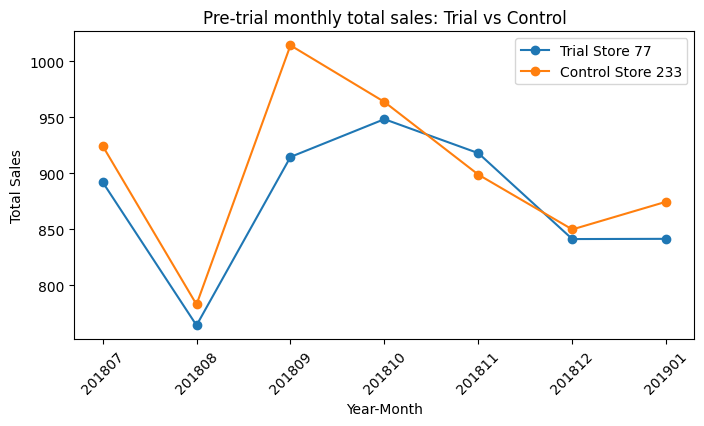

In [44]:
import matplotlib.pyplot as plt
Trial1=pre_trial_store[pre_trial_store['Store Number']==86]
Trial1_grouped = Trial1.groupby('year_mm')['Total Sales'].sum().reset_index()
Control1=pre_trial_store[pre_trial_store['Store Number']==155]
Control1_grouped = Control1.groupby('year_mm')['Total Sales'].sum().reset_index()
plt.figure(figsize=(8,4))

plt.plot(Trial1_grouped['year_mm'].astype(str), Trial1_grouped['Total Sales'], 
         marker='o', label='Trial Store 77')

plt.plot(Control1_grouped['year_mm'].astype(str), Control1_grouped['Total Sales'], 
         marker='o', label='Control Store 233')

plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.title('Pre-trial monthly total sales: Trial vs Control')
plt.xticks(rotation=45)
plt.legend()
plt.show()

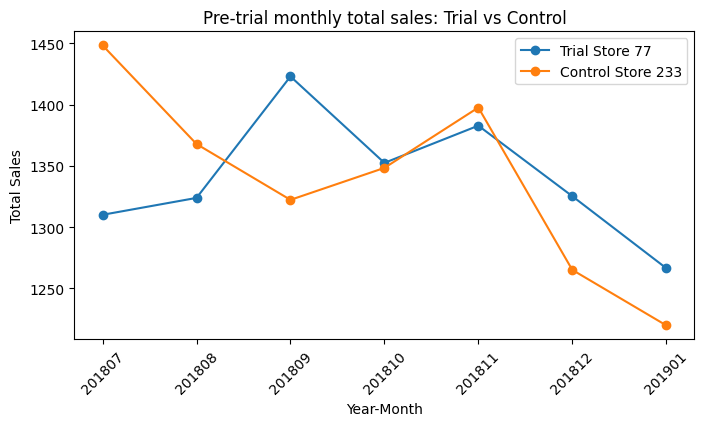

In [45]:
import matplotlib.pyplot as plt
Trial1=pre_trial_store[pre_trial_store['Store Number']==88]
Trial1_grouped = Trial1.groupby('year_mm')['Total Sales'].sum().reset_index()
Control1=pre_trial_store[pre_trial_store['Store Number']==237]
Control1_grouped = Control1.groupby('year_mm')['Total Sales'].sum().reset_index()
plt.figure(figsize=(8,4))

plt.plot(Trial1_grouped['year_mm'].astype(str), Trial1_grouped['Total Sales'], 
         marker='o', label='Trial Store 77')

plt.plot(Control1_grouped['year_mm'].astype(str), Control1_grouped['Total Sales'], 
         marker='o', label='Control Store 233')

plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.title('Pre-trial monthly total sales: Trial vs Control')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [46]:
#QUESTION 6 (CALCULATING UPLIFTING OF TOTAL SALES AND CUSTOMER)
def uplift(trial,control):
    Trial_pre=matrix[(matrix['Store Number']==trial)&(matrix['year_mm']<201902)]
    Trial_post=matrix[(matrix['Store Number']==trial)&(matrix['year_mm']>201902)]
    control_pre=matrix[(matrix['Store Number']==control)&(matrix['year_mm']<201902)]
    control_post=matrix[(matrix['Store Number']==control)&(matrix['year_mm']>201902)]
#grouping by months and sum
    Trial_gr=Trial_pre.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
    control_gr=control_pre.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
    Trial_go=Trial_post.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
    control_go=control_post.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
#merging
    pre=pd.merge(Trial_gr,control_gr,on='year_mm')
    post=pd.merge(Trial_go,control_go,on='year_mm')
#ratios
    pre['ratio_ts']=pre['Total Sales_x']/pre['Total Sales_y']
    pre['ratio_Noc']=pre['Number of Customers_x']/pre['Number of Customers_y']
    post['ratio_ts']=post['Total Sales_x']/post['Total Sales_y']
    post['ratio_Noc']=post['Number of Customers_x']/post['Number of Customers_y']
###averages
    pre_avg_ts=pre['ratio_ts'].mean()
    pre_avg_Noc=pre['ratio_Noc'].mean()
    post_avg_ts=post['ratio_ts'].mean()
    post_avg_Noc=post['ratio_Noc'].mean()
#Calculating uplifting
    uplift_ts=(post_avg_ts-pre_avg_ts)/pre_avg_ts*100
    uplift_Noc=(post_avg_Noc-pre_avg_Noc)/pre_avg_Noc*100
    return {
        'Trial Store': trial,
        'Control Store': control,
        'Uplifting in Sales (%)': round(uplift_ts, 2),
        'Uplifting in Customers (%)': round(uplift_Noc, 2)
    }

trial = [77, 86, 88]
control = [233, 155, 237]
results = []
for trial, control in zip(trial, control):
    results.append(uplift(trial, control))
# Convert to DataFrame
Summary_uplifting = pd.DataFrame(results)
print (Summary_uplifting)

   Trial Store  Control Store  Uplifting in Sales (%)  \
0           77            233                   23.46   
1           86            155                    8.65   
2           88            237                   16.62   

   Uplifting in Customers (%)  
0                       18.86  
1                        7.39  
2                        5.60  


In [62]:
#
from scipy.stats import ttest_ind
def uplift(trial,control):
    Trial_pre=matrix[(matrix['Store Number']==trial)&(matrix['year_mm']<201902)]
    Trial_post=matrix[(matrix['Store Number']==trial)&(matrix['year_mm']>201902)]
    control_pre=matrix[(matrix['Store Number']==control)&(matrix['year_mm']<201902)]
    control_post=matrix[(matrix['Store Number']==control)&(matrix['year_mm']>201902)]
#grouping by months and sum
    Trial_gr=Trial_pre.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
    control_gr=control_pre.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
    Trial_go=Trial_post.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
    control_go=control_post.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
#merging
    pre=pd.merge(Trial_gr,control_gr,on='year_mm')
    post=pd.merge(Trial_go,control_go,on='year_mm')
#ratios
    pre['ratio_ts']=pre['Total Sales_x']/pre['Total Sales_y']
    pre['ratio_Noc']=pre['Number of Customers_x']/pre['Number of Customers_y']
    post['ratio_ts']=post['Total Sales_x']/post['Total Sales_y']
    post['ratio_Noc']=post['Number of Customers_x']/post['Number of Customers_y']
#p value
    t_stat, p_value = ttest_ind(post['ratio_ts'], pre['ratio_ts'], equal_var=False)
    t_stat_cust, p_value_cust = ttest_ind(post['ratio_Noc'], pre['ratio_Noc'], equal_var=False)
    return{
    'Trial Store':trial,
    'Control Store':control,
    'T- test statistic': round(t_stat, 2),
    'P-value': round(p_value, 2)
    }
        
trial = [77, 86, 88]
control = [233, 155, 237]
results_total_sales = []
for trial, control in zip(trial, control):
    results_total_sales.append(uplift(trial, control))
    
# Convert to DataFrame
test_summary_totalsales = pd.DataFrame(results_total_sales)
print (test_summary_totalsales)


   Trial Store  Control Store  T- test statistic  P-value
0           77            233               1.42     0.24
1           86            155               1.11     0.34
2           88            237               4.67     0.00


In [63]:
#
from scipy.stats import ttest_ind
def uplift(trial,control):
    Trial_pre=matrix[(matrix['Store Number']==trial)&(matrix['year_mm']<201902)]
    Trial_post=matrix[(matrix['Store Number']==trial)&(matrix['year_mm']>201902)]
    control_pre=matrix[(matrix['Store Number']==control)&(matrix['year_mm']<201902)]
    control_post=matrix[(matrix['Store Number']==control)&(matrix['year_mm']>201902)]
#grouping by months and sum
    Trial_gr=Trial_pre.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
    control_gr=control_pre.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
    Trial_go=Trial_post.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
    control_go=control_post.groupby('year_mm').agg({'Total Sales':'sum','Number of Customers':'sum'}).reset_index()
#merging
    pre=pd.merge(Trial_gr,control_gr,on='year_mm')
    post=pd.merge(Trial_go,control_go,on='year_mm')
#ratios
    pre['ratio_ts']=pre['Total Sales_x']/pre['Total Sales_y']
    pre['ratio_Noc']=pre['Number of Customers_x']/pre['Number of Customers_y']
    post['ratio_ts']=post['Total Sales_x']/post['Total Sales_y']
    post['ratio_Noc']=post['Number of Customers_x']/post['Number of Customers_y']
#p value
    t_stat_cust, p_value_cust = ttest_ind(post['ratio_Noc'], pre['ratio_Noc'], equal_var=False)
    return{
    'Trial Store':trial,
    'Control Store':control,
    'T- test statistic': round(t_stat_cust, 2),
    'P-value': round(p_value_cust, 2)
    }     
trial = [77, 86, 88]
control = [233, 155, 237]
results_customer = []
for trial, control in zip(trial, control):
    results_customer.append(uplift(trial, control))

# Convert to DataFrame
test_summary_customer = pd.DataFrame(results_customer)
print (test_summary_customer)


   Trial Store  Control Store  T- test statistic  P-value
0           77            233               1.36     0.27
1           86            155               1.40     0.25
2           88            237               1.85     0.16
